# Feature Matching

This notebook evaluates feature matching performance for a number of test scenarios.

TODO: There are images that clearly have bad homographies, but are added together nevertheless.

TODO: Refactor the code in here to use the code that the mosaics use.

# Setup

## Imports

In [1]:
# import copy
import glob
import itertools
import os
import time

In [2]:
import cv2
import numpy as np
import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.utils import check_random_state
import tqdm.notebook
import yaml

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import seaborn as sns
sns.set_style('white')

In [4]:
from night_horizons import utils, raster

## Settings

In [5]:
with open('./config.yml', "r", encoding='UTF-8') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
local_settings = {
    # Filetree settings
    'test_images_dir': '../test_data/feature_matching/',
    'src_format': 'src_{}.tiff',
    'dst_format': 'dst_{}.tiff',

    # Feature matching options
    'feature_detectors': [
        ('ORB', {}),
        ('SIFT', {}),
        # Still marked as patented in the opencv version I'm using.
        # (cv2.xfeatures2d.SURF_create, {}),
        ('AKAZE', {}),
        # ('BRISK', {}),
        # Does not seem to be fully implemented in OpenCV
        # ('FastFeatureDetector', {}),
        # Does not seem to be fully implemented in OpenCV
        # ('MSER', {}),
    ],
    'feature_matchers': [
        # TODO: Explore other feature matchers.
        ('BFMatcher', {}),
        # ('FlannBasedMatcher', {}),
        # ('BFMatcher', {'k': [10,]}),
        # TODO: Try Grid-based Motion Statistics. Very fast, but more complicated.
    ],
    'transform_param_grid': {
        'method': [
            cv2.RANSAC,
            # cv2.RHO,
            # These don't really show promise
            # cv2.LMEDS,
            # 0,
        ],
        # 'ransacReprojThreshold': np.arange(1, 10),
        # 'maxIters': [100, 1000, 2000, 10000],
        'n_matches_used': [10, 100, 500, None],
    },

    # Analysis parameters
    'det_min': 0.6,
    'n_images': 10000,
    'show_images': True,
}
settings.update(local_settings)

## Parse Settings

In [7]:
# Initialize the feature detectors
feature_detectors = []
for subsettings in settings['feature_detectors']:

    if len(subsettings[1]) == 0:
        feature_detectors.append(subsettings)
        continue
    
    # Generate all permutations of values
    param_grid = subsettings[1]
    keys, values = zip(*param_grid.items())
    permutations = itertools.product(*values)
    
    list_addition = [
        (
            subsettings[0],
            dict(zip(keys, permutation))
        )
        for permutation in permutations
    ]
    feature_detectors += list_addition

In [8]:
# Initialize the feature matchers
feature_matchers = []
for subsettings in settings['feature_matchers']:

    if len(subsettings[1]) == 0:
        feature_matchers.append(subsettings)
        continue
    
    # Generate all permutations of values
    param_grid = subsettings[1]
    keys, values = zip(*param_grid.items())
    permutations = itertools.product(*values)
    
    list_addition = [
        (
            subsettings[0],
            dict(zip(keys, permutation))
        )
        for permutation in permutations
    ]
    feature_matchers += list_addition

In [9]:
# Get transform kwargs

# Generate all permutations of values
param_grid = settings['transform_param_grid']
keys, values = zip(*param_grid.items())
permutations = itertools.product(*values)

transform_kwargs = [
    dict(zip(keys, permutation))
    for permutation in permutations
]

## Code

In [10]:
class FeatureCombiner:

    def __init__(self, src_fp, dst_fp):

        self.src_fp = src_fp
        self.src_image = raster.Image.open(src_fp)
        self.src_img = self.src_image.img_int
        self.dst_fp = dst_fp
        self.dst_image = raster.Image.open(dst_fp)
        self.dst_img = self.dst_image.img_int

    def show_before(self):

        subplot_mosaic = [['dst_img', 'src_img']]
        fig = plt.figure(figsize=(20,10))
        ax_dict = fig.subplot_mosaic(subplot_mosaic)
        
        ax = ax_dict['dst_img']
        self.dst_image.show(ax=ax, img='semitransparent_img')
        
        ax = ax_dict['src_img']
        self.src_image.show(ax=ax, img='semitransparent_img')
        
        plt.tight_layout()

    def show_after(self):
        
        # View results
        subplot_mosaic = [['warped_img', 'blended_img']]
        fig = plt.figure(figsize=(20,10))
        ax_dict = fig.subplot_mosaic(subplot_mosaic)
        
        ax = ax_dict['warped_img']
        self.warped_image.show(ax=ax, img='semitransparent_img')
        
        ax = ax_dict['blended_img']
        self.blended_image.show(ax=ax, img='semitransparent_img')
        
        plt.tight_layout()

    def detect_and_transform(self, feature_detector, feature_matcher, transform_kwargs, pbar=None):

        start = time.time()

        # Get keypoints
        src_kp, src_des = feature_detector.detectAndCompute(self.src_img, None)
        dst_kp, dst_des = feature_detector.detectAndCompute(self.dst_img, None)
        if pbar is not None:
            pbar.update(1)
        
        # Get transform
        M, info = utils.calc_warp_transform(
            src_kp,
            src_des,
            dst_kp,
            dst_des,
            feature_matcher,
            **transform_kwargs
        )
        if pbar is not None:
            pbar.update(1)
            
        # Check transform
        valid_M, abs_det_M = utils.validate_warp_transform(M, det_min=settings['det_min'])
        if pbar is not None:
            pbar.update(1)
            
        duration = time.time() - start

        info['valid_M'] = valid_M
        info['abs_det_M'] = abs_det_M
        info['duration'] = duration
        info['M'] = M

        return info

    def warp_and_blend(self, M):
        
        # Warp and blend
        warped_img = cv2.warpPerspective(self.src_img, M, (self.dst_img.shape[1], self.dst_img.shape[0]))
        self.warped_image = raster.Image(warped_img)
        blended_img = utils.blend_images(
            src_img=warped_img,
            dst_img=self.dst_img,
        )
        self.blended_image = raster.Image(blended_img[:, :, :3])

    def grid_search(self, feature_detectors, feature_matchers, transform_kwargs):

 
        n_fd = len(feature_detectors)
        n_fm = len(feature_matchers)
        n_t = len(transform_kwargs)
        n_stages = 3
        n_tot = n_fd * n_fm * n_t * n_stages

        data = {}
        with tqdm.notebook.tqdm(total=n_tot) as pbar:
        
            for i, fd_settings in enumerate(feature_detectors):

                if isinstance(fd_settings[0], str):
                    fd_constructor = getattr(cv2, '{}_create'.format(fd_settings[0]))
                else:
                    fd_constructor = fd_settings[0]
        
                feature_detector = fd_constructor(**fd_settings[1])
                
                for j, fm_settings in enumerate(feature_matchers):

                    for k, t_kwargs in enumerate(transform_kwargs):
        
                        feature_matcher = getattr(cv2, '{}'.format(fm_settings[0]))(**fm_settings[1])
    
                        result_ijk = self.detect_and_transform(feature_detector, feature_matcher, t_kwargs, pbar)
    
                        for key, item in result_ijk.items():
                            data.setdefault(key, []).append(item)
            
                        data.setdefault('i_fd', []).append(i)
                        data.setdefault('j_fm', []).append(j)
                        data.setdefault('k_tk', []).append(k)
        
        df = pd.DataFrame(data)

        # Measure of how warped the image is
        df['warp_factor'] = np.abs(np.log10(np.abs(df['abs_det_M'])))

        # Identify the best set of parameters
        valid_df = df.loc[df['valid_M']]
        if len(valid_df) > 0:
            best_ind = valid_df.index[valid_df['duration'].argmin()]
        else:
            best_ind = df.index[df['warp_factor'].argmin()]
        best_row = df.loc[best_ind]
        t_best_ind = pd.Timedelta(settings['n_images'] * best_row['duration'], unit='second')

        # Results
        gs_info = {
            'n_valid': len(valid_df),
            'best_ind': best_ind,
            't_best_ind': t_best_ind,
            'best_fd': feature_detectors[best_row['i_fd']],
            'best_fm': feature_matchers[best_row['j_fm']],
            'best_tk': transform_kwargs[best_row['k_tk']],
        }

        if len(valid_df) > 0:
            print(
                f'''Grid search complete.
                    {gs_info['n_valid']} valid results.
                    Best valid time was {best_row['duration']:.2g} seconds, for an estimated total time of {gs_info['t_best_ind']}.
                    The best feature detector was {gs_info['best_fd']}
                    The best feature matcher was {gs_info['best_fm']}
                    The best transform kwargs were {gs_info['best_tk']}
                '''
            )
        else:
            print(
                f'''No successes found. Closest det_min was 
                '''
            )

        self.df = df
        self.best_row = best_row
        self.gs_info = gs_info

        return df, best_row, gs_info   


# Image Pairs

## A Particular Set

In [12]:
i = 0
src_fp = os.path.join(settings['test_images_dir'], settings['src_format'].format(i))
dst_fp = os.path.join(settings['test_images_dir'], settings['dst_format'].format(i))
fc = FeatureCombiner(src_fp, dst_fp)

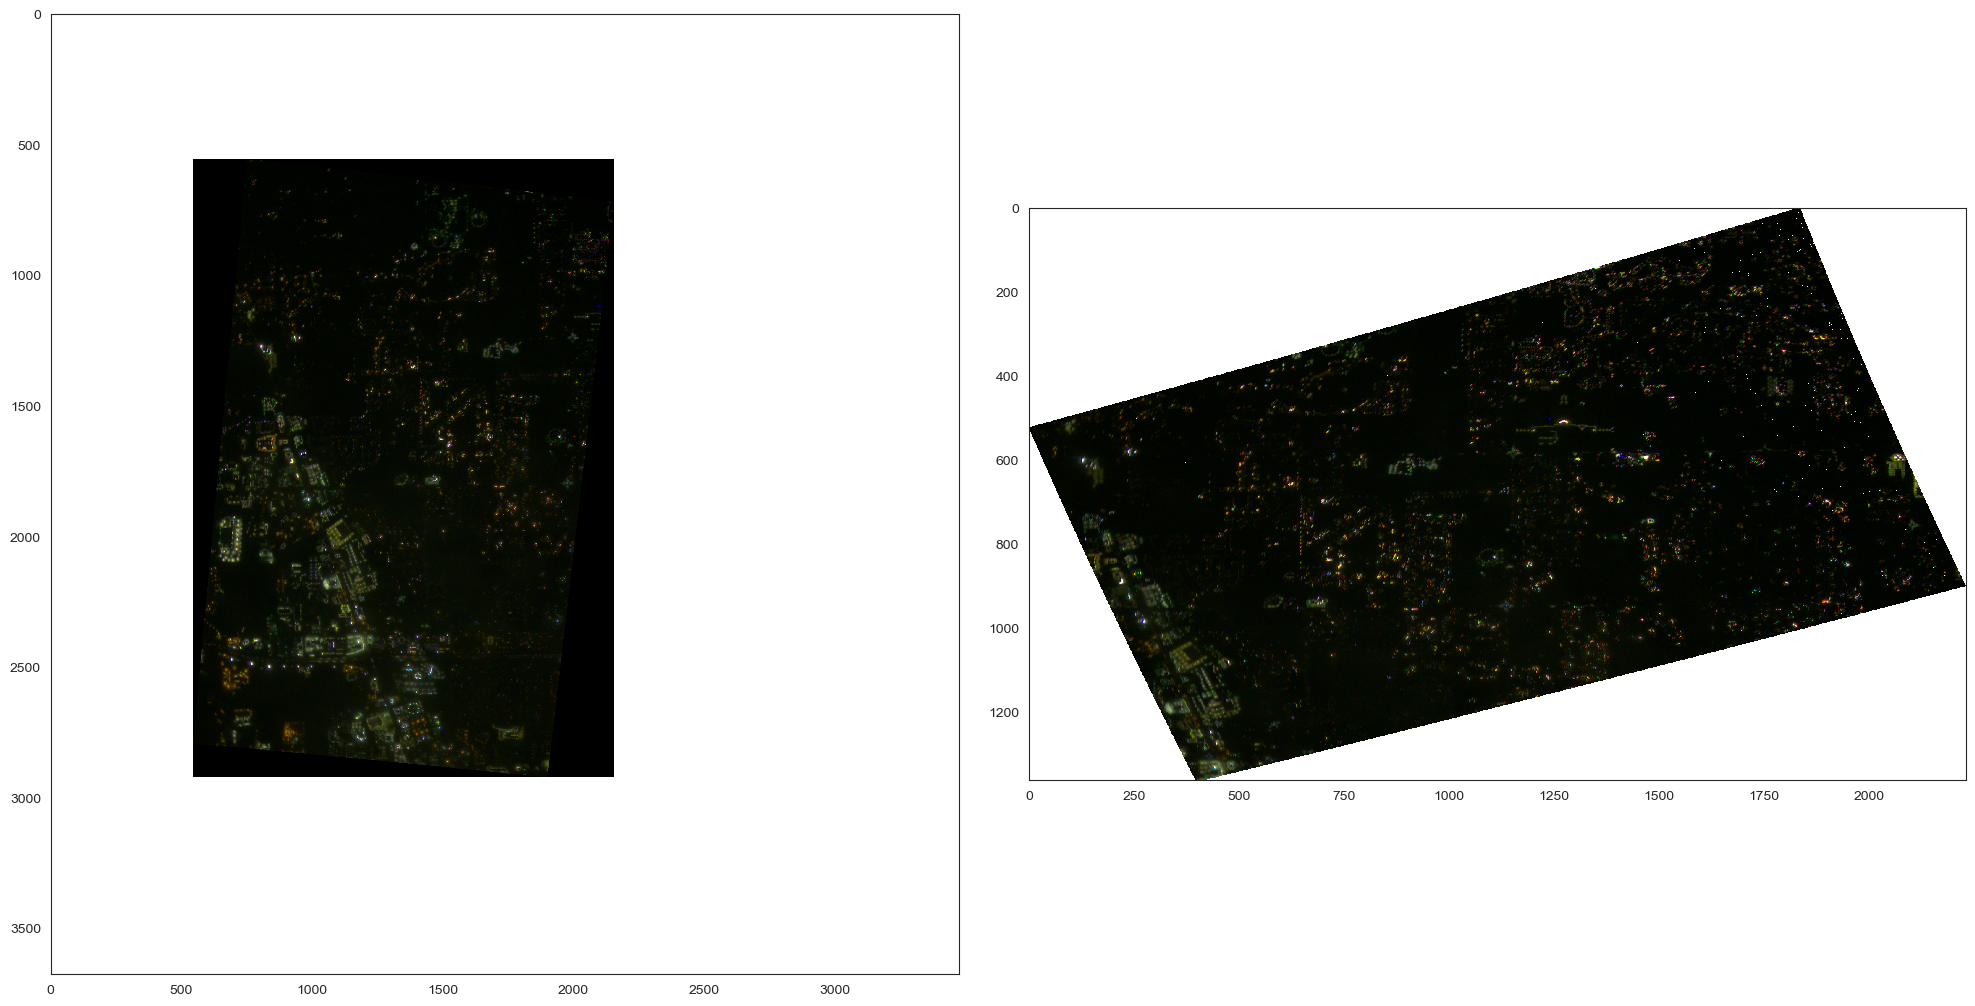

In [13]:
if settings['show_images']:
    fc.show_before()

In [14]:
df, best_row, grid_search_results = fc.grid_search(feature_detectors, feature_matchers, transform_kwargs)

  0%|          | 0/36 [00:00<?, ?it/s]

Grid search complete.
                    3 valid results.
                    Best valid time was 0.96 seconds, for an estimated total time of 0 days 02:40:26.727104187.
                    The best feature detector was ('AKAZE', {})
                    The best feature matcher was ('BFMatcher', {})
                    The best transform kwargs were {'method': 8, 'n_matches_used': None}
                


In [15]:
fc.warp_and_blend(best_row['M'])

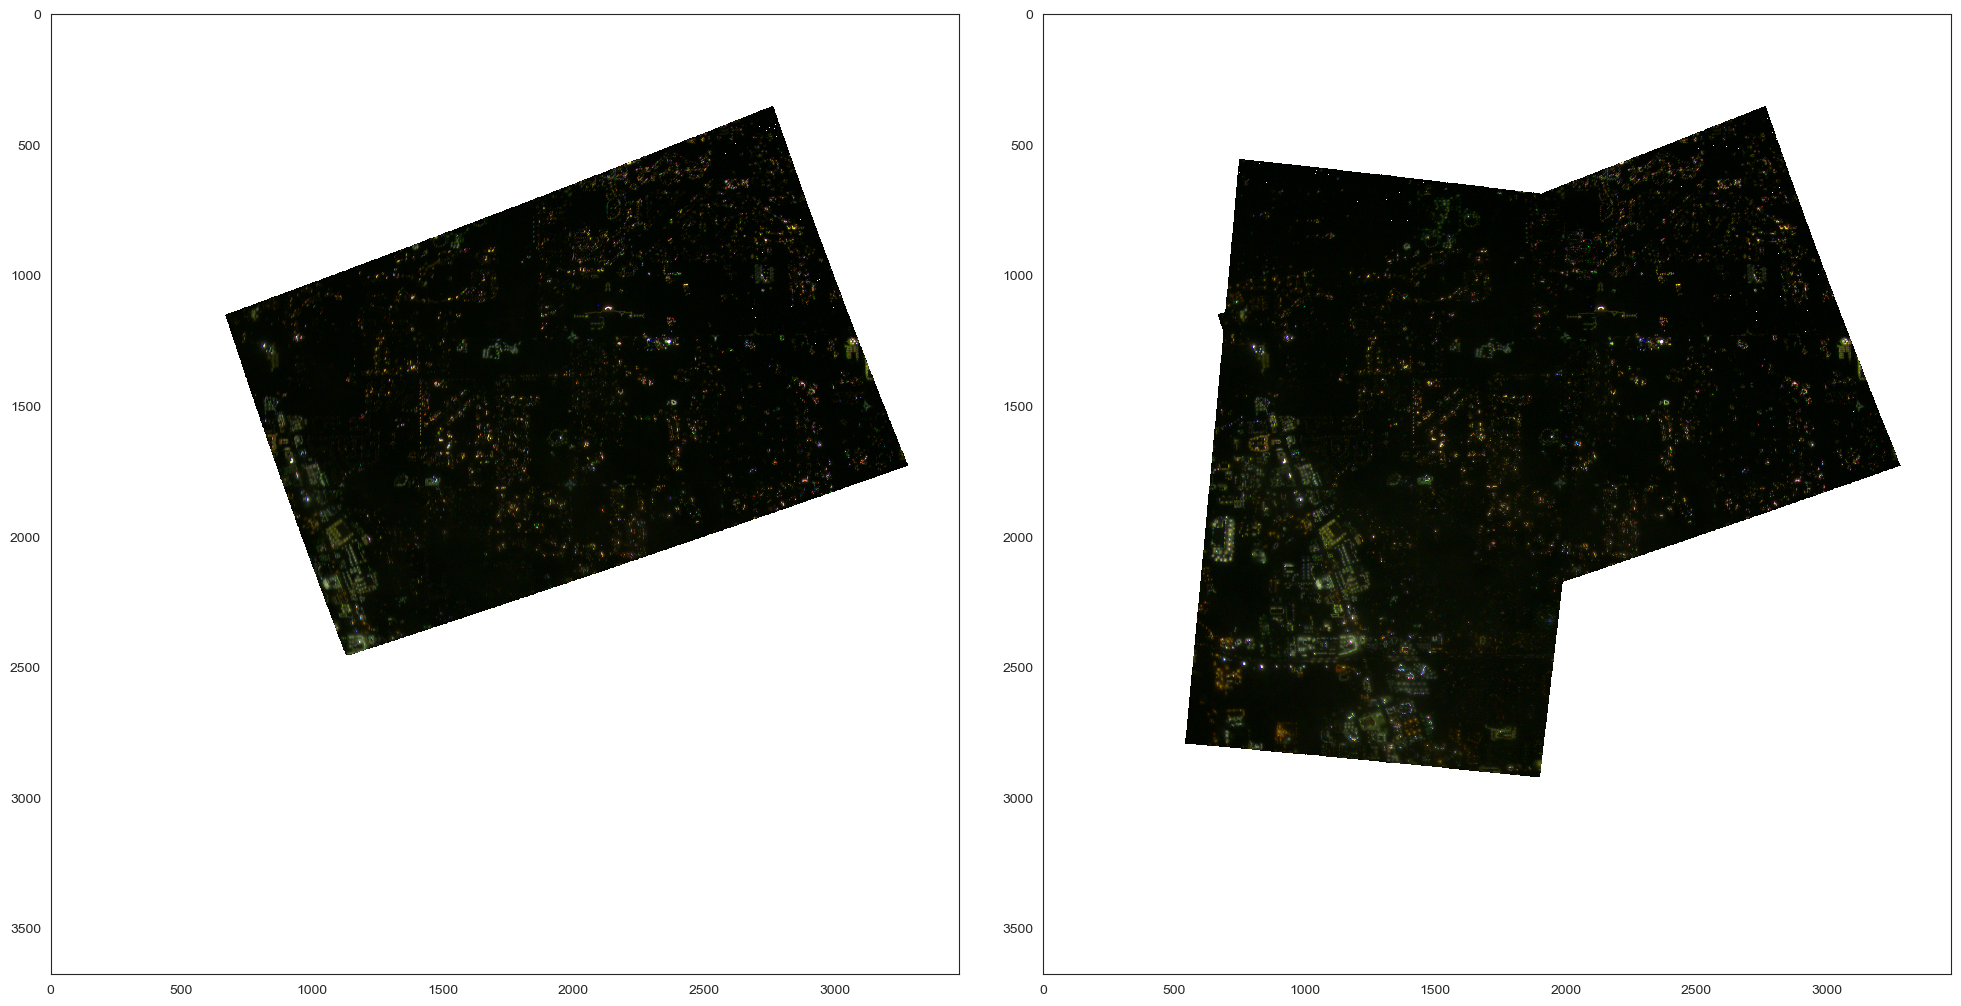

In [16]:
if settings['show_images']:
    fc.show_after()

In [18]:
df['set'] = i
results.append(df)

## All Sets

In [19]:
results = []

In [20]:
src_fps = glob.glob(os.path.join(settings['test_images_dir'], settings['src_format'].format('*')))

In [21]:
src_fps

['../test_data/feature_matching/src_4.tiff',
 '../test_data/feature_matching/src_8.tiff',
 '../test_data/feature_matching/src_10.tiff',
 '../test_data/feature_matching/src_11.tiff',
 '../test_data/feature_matching/src_9.tiff',
 '../test_data/feature_matching/src_5.tiff',
 '../test_data/feature_matching/src_2.tiff',
 '../test_data/feature_matching/src_3.tiff',
 '../test_data/feature_matching/src_0.tiff',
 '../test_data/feature_matching/src_1.tiff',
 '../test_data/feature_matching/src_6.tiff',
 '../test_data/feature_matching/src_12.tiff',
 '../test_data/feature_matching/src_7.tiff']

In [ ]:

src_fp = os.path.join(settings['test_images_dir'], settings['src_format'].format(i))
dst_fp = os.path.join(settings['test_images_dir'], settings['dst_format'].format(i))
fc = FeatureCombiner(src_fp, dst_fp)


df, best_row, grid_search_results = fc.grid_search(feature_detectors, feature_matchers, transform_kwargs)

fc.warp_and_blend(best_row['M'])

df['set'] = i
results.append(df)

## Summarize

In [36]:
df = pd.concat(results, ignore_index=True)

In [37]:
df['ijk'] = 'i' + df['i_fd'].astype(str) + '_j' + df['j_fm'].astype(str) + '_k' + df['k_tk'].astype(str)

In [38]:
valid_df = df.loc[df['valid_M']]

In [39]:
n_sets = pd.unique(df['set']).size

### Overview

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

(0.0, 10.35539613806179)

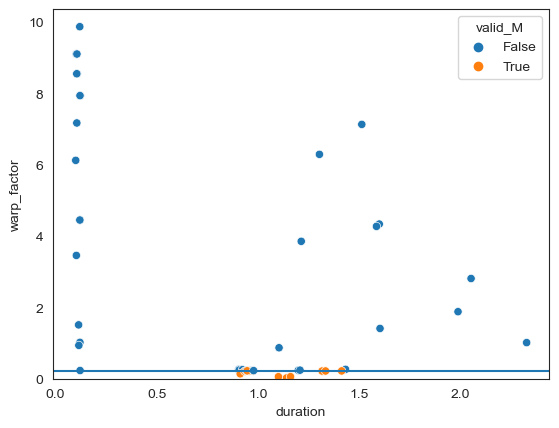

In [40]:
sns.scatterplot(
    data=df,
    x='duration',
    y='warp_factor',
    hue='valid_M',
)

ax = plt.gca()
ax.axhline(np.abs(np.log10(settings['det_min'])))
ax.set_ylim(0, ax.get_ylim()[1])

### Identify Promising Parameters

In [42]:
# Feature detectors that work across all image pairs
n_valid_sets = valid_df.groupby('i_fd')['set'].nunique()
promising_fd = [feature_detectors[_] for _ in n_valid_sets.index[n_valid_sets==n_sets]]
promising_fd

[('AKAZE', {})]

In [43]:
# Feature matchers that work across all image pairs
n_valid_sets = valid_df.groupby('j_fm')['set'].nunique()
promising_fm = [feature_matchers[_] for _ in n_valid_sets.index[n_valid_sets==n_sets]]
promising_fm

[('BFMatcher', {})]

In [44]:
# Transform parameters that work across all image pairs
n_valid_sets = valid_df.groupby('k_tk')['set'].nunique()
promising_t_kwargs = [transform_kwargs[_] for _ in n_valid_sets.index[n_valid_sets==n_sets]]
method_map = {
    getattr(cv2, method): method
    for method in ['RANSAC', 'LMEDS', 'RHO']
}
promising_t_kwargs = [
    {
        key:(method_map[value] if key == 'method' else value)
        for key, value in t_kwargs.items()
    } for t_kwargs in promising_t_kwargs
]
promising_t_kwargs

[]

In [45]:
# And now the combinations that are fully good
ijk_groups = valid_df.groupby('ijk')
n_valid_sets = ijk_groups['set'].nunique()
is_good = n_valid_sets == n_sets
good_ijks = n_valid_sets.index[is_good]

In [46]:
if is_good.sum() > 0:
    # Convert into a dataframe
    good_df = ijk_groups.first().loc[good_ijks]
    good_df['duration'] = ijk_groups['duration'].mean().loc[good_ijks]
    good_df = good_df.sort_values('duration')
    best_row = good_df.iloc[0]

    # Print the best (quickest while still valid) combination
    print(
        feature_detectors[best_row['i_fd']],
        feature_matchers[best_row['j_fm']],
        transform_kwargs[best_row['k_tk']]
    )
else:
    print('No single set of parameters works for all images.')

No single set of parameters works for all images.
